In [1]:
# Setup & Downloads
import os, sys, time, torch
from huggingface_hub import snapshot_download

print("Python:", sys.version)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    raise SystemExit("No GPU found. Please select a GPU runtime (A100 recommended).")
# USER CONFIG
MODEL_ID = "google/vit-large-patch16-224"
BASE_DIR = "/content/vit_lora_ft"
DATA_DIR = "/content/dataset"
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")

NUM_LABELS = 102
IMAGE_SIZE = 224
BATCH_SIZE = 100
EPOCHS = 6
LR = 2e-5

os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)

# DOWNLOAD MODEL FROM HUGGINGFACE
print("\n=== Downloading ViT model from HuggingFace ===")
model_cache_dir = snapshot_download(
    repo_id=MODEL_ID,
    local_dir=os.path.join(BASE_DIR, "hf_model")
)
print("Model downloaded to:", model_cache_dir)

# 1. Enter Kaggle credentials
KAGGLE_USERNAME = input("Enter your Kaggle Username: ").strip()
KAGGLE_KEY = input("Enter your Kaggle API Key: ").strip()

# Write kaggle.json
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

with open(f"{kaggle_dir}/kaggle.json", "w") as f:
    f.write(f'{{"username":"{KAGGLE_USERNAME}","key":"{KAGGLE_KEY}"}}')

os.chmod(f"{kaggle_dir}/kaggle.json", 0o600)

print("Kaggle API configured!")

# 2. Download dataset zip
!kaggle datasets download -d nunenuh/pytorch-challange-flower-dataset -p {DATA_DIR}

# 3. Unzip dataset
print("\n=== Extracting dataset ===")
!unzip -o "{DATA_DIR}/pytorch-challange-flower-dataset.zip" -d {DATA_DIR}

print("\nDataset ready at:", DATA_DIR)
print("Subfolders:", os.listdir(DATA_DIR))


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
BASE_DIR: /content/vit_lora_ft

=== Downloading ViT model from HuggingFace ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dataset/train/48/image_04692.jpg  
  inflating: /content/dataset/dataset/train/48/image_04694.jpg  
  inflating: /content/dataset/dataset/train/48/image_04695.jpg  
  inflating: /content/dataset/dataset/train/49/image_06198.jpg  
  inflating: /content/dataset/dataset/train/49/image_06199.jpg  
  inflating: /content/dataset/dataset/train/49/image_06200.jpg  
  inflating: /content/dataset/dataset/train/49/image_06201.jpg  
  inflating: /content/dataset/dataset/train/49/image_06203.jpg  
  inflating: /content/dataset/dataset/train/49/image_06204.jpg  
  inflating: /content/dataset/dataset/train/49/image_06205.jpg  
  inflating: /content/dataset/dataset/train/49/image_06206.jpg  
  inflating: /content/dataset/dataset/train/49/image_06207.jpg  
  inflating: /content/dataset/dataset/train/49/image_06208.jpg  
  inflating: /content/dataset/dataset/train/49/image_06211.jpg  
  inflating: /content/dataset/dataset/t

In [2]:
# Install required Python packages for training, LoRA, and quantization.
!pip install -q --upgrade pip
!pip install -q transformers accelerate datasets timm torchvision bitsandbytes safetensors evaluate matplotlib seaborn
!pip install -q git+https://github.com/huggingface/peft.git

# Confirm installs
import importlib, sys
import transformers, peft
print("transformers", transformers.__version__)
print("peft available")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
transformers 4.57.3
peft available


In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# 1. Define Transforms (Required for ViT)
# ViT-Large usually expects 224x224 images normalized to ImageNet mean/std
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# 2. Define Custom Dataset for Test
class FlatImageFolder(Dataset):
    """Dataset for images stored directly in a folder (not in class subfolders)"""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all image files
        self.image_files = [f for f in os.listdir(root_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Return dummy label since test set doesn't need labels
        return image, 0

# 3. Load Datasets
# Adjust paths if your dataset structure is different after unzipping
train_dir = "/content/dataset/dataset/train"
valid_dir = "/content/dataset/dataset/valid"
test_dir  = "/content/dataset/dataset/test"

# Check if directories exist to avoid errors
if not os.path.exists(train_dir):
    print(f"Warning: {train_dir} not found. Check your unzip path.")
else:
    train_ds = ImageFolder(train_dir, transform=train_transforms)
    valid_ds = ImageFolder(valid_dir, transform=eval_transforms)
    # Use custom dataset for test if images are flat
    test_ds = FlatImageFolder(test_dir, transform=eval_transforms)

    # 4. Create DataLoaders
    # Note: BATCH_SIZE must be defined (it was defined in Cell 1, so it should be available)
    # If BATCH_SIZE is missing, uncomment the line below:
    # BATCH_SIZE = 100

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    print("Dataset sizes (train, valid, test):", len(train_ds), len(valid_ds), len(test_ds))
    print(f"Number of classes: {len(train_ds.classes)}")

Dataset sizes (train, valid, test): 6552 818 819
Number of classes: 102


In [6]:
# Utility helpers for saving artifacts, computing eval metrics, and reading GPU memory.
import shutil, time
import torch
import torch.nn.functional as F

def save_and_zip(dir_path, zip_name=None):
    if zip_name is None:
        zip_name = os.path.basename(dir_path.rstrip("/")) + ".zip"
    zip_path = os.path.join("/content", zip_name)
    shutil.make_archive(zip_path.replace(".zip",""), 'zip', dir_path)
    try:
        from google.colab import files
        files.download(zip_path)
    except Exception:
        print("Download not available in this environment. Zip at:", zip_path)
    return zip_path

def get_gpu_mem():
    if torch.cuda.is_available():
        return {
            "allocated_gb": torch.cuda.memory_allocated()/(1024**3),
            "reserved_gb":  torch.cuda.memory_reserved()/(1024**3)
        }
    return {}

def evaluate(model, dataloader, device):
    model.eval()
    total = 0
    top1 = 0
    top5 = 0
    total_loss = 0.0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            out = model(imgs)
            logits = out.logits
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item() * imgs.size(0)
            _, preds = logits.topk(5, dim=1, largest=True, sorted=True)
            correct = preds.eq(labels.view(-1,1).expand_as(preds))
            top1 += correct[:, :1].sum().item()
            top5 += correct.sum().item()
            total += imgs.size(0)
    return {"loss": total_loss/total, "top1": top1/total, "top5": top5/total}

In [7]:
# Load FP16 ViT baseline and configure LoRA adapters via PEFT.
from transformers import AutoModelForImageClassification
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "google/vit-large-patch16-224"
NUM_LABELS = 102

print("Loading FP16 base model...")
model_fp16 = AutoModelForImageClassification.from_pretrained(
    MODEL_ID,
    num_labels=NUM_LABELS,
    torch_dtype=torch.float16,
    ignore_mismatched_sizes=True  # This allows the classifier head to be reinitialized
)
model_fp16.to(device)

# LoRA config: small-rank adapters to reduce trainable parameters
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

use_lora = True
try:
    model_for_lora = prepare_model_for_kbit_training(model_fp16)
    model_lora = get_peft_model(model_for_lora, lora_config)
    print("LoRA applied. Trainable params:", sum(p.numel() for p in model_lora.parameters() if p.requires_grad))
except Exception as e:
    print("LoRA apply failed; falling back to full fine-tuning. Error:", e)
    use_lora = False
    model_lora = model_fp16

print(f"\nModel device: {next(model_lora.parameters()).device}")
print(f"Model dtype: {next(model_lora.parameters()).dtype}")

Loading FP16 base model...


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([102, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied. Trainable params: 3538944

Model device: cuda:0
Model dtype: torch.float32


In [8]:
# Training loop using mixed precision. Trains only LoRA params if LoRA was applied.
from torch.optim import AdamW
from collections import defaultdict
from tqdm import tqdm
import torch.nn.functional as F
import time
import torch


# Define evaluation function
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                out = model(pixel_values=imgs)
                loss = F.cross_entropy(out.logits, labels)

            total_loss += loss.item() * imgs.size(0)

            # Top-1 accuracy
            _, pred = out.logits.max(1)
            correct_top1 += pred.eq(labels).sum().item()

            # Top-5 accuracy
            _, pred_top5 = out.logits.topk(5, 1, True, True)
            correct_top5 += pred_top5.eq(labels.view(-1, 1).expand_as(pred_top5)).sum().item()

            total += labels.size(0)

    return {
        "loss": total_loss / total,
        "top1": correct_top1 / total,
        "top5": correct_top5 / total
    }


# Define GPU memory helper function
def get_gpu_mem():
    """Helper function to get GPU memory usage"""
    if torch.cuda.is_available():
        return f"{torch.cuda.memory_allocated() / 1024**3:.2f}GB"
    return "N/A"


# Setup training
model_train = model_lora.to(device)

if use_lora:
    params = [p for _, p in model_train.named_parameters() if p.requires_grad]
else:
    params = model_train.parameters()

optimizer = AdamW(params, lr=2e-5)
scaler = torch.amp.GradScaler('cuda')

EPOCHS = 6
history = defaultdict(list)
start_all = time.time()

# Training loop
for epoch in range(1, EPOCHS+1):
    model_train.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    t0 = time.time()

    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            out = model_train(pixel_values=imgs)
            loss = F.cross_entropy(out.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({"loss": float(loss.detach().cpu().numpy())})

    epoch_time = time.time() - t0
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    val_stats = evaluate(model_train, valid_loader, device)

    history["epoch"].append(epoch)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(val_stats["loss"])
    history["val_top1"].append(val_stats["top1"])
    history["val_top5"].append(val_stats["top5"])
    history["epoch_time"].append(epoch_time)

    print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={val_stats['loss']:.4f}, "
          f"val_top1={val_stats['top1']:.4f}, val_top5={val_stats['top5']:.4f}, "
          f"time={epoch_time:.1f}s, GPU={get_gpu_mem()}")

total_train_time = time.time() - start_all
print(f"\nTotal training time: {total_train_time:.1f}s ({total_train_time/60:.2f} minutes)")
print(f"Average time per epoch: {total_train_time/EPOCHS:.1f}s")

Epoch 1: 100%|██████████| 66/66 [00:30<00:00,  2.15it/s, loss=4.61]


Epoch 1: train_loss=4.7567, val_loss=4.6202, val_top1=0.0098, val_top5=0.0868, time=30.7s, GPU=1.23GB


Epoch 2: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s, loss=4.04]


Epoch 2: train_loss=4.4295, val_loss=4.0860, val_top1=0.1357, val_top5=0.3545, time=28.5s, GPU=1.23GB


Epoch 3: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s, loss=3.39]


Epoch 3: train_loss=3.7935, val_loss=3.3883, val_top1=0.3814, val_top5=0.5513, time=28.5s, GPU=1.23GB


Epoch 4: 100%|██████████| 66/66 [00:28<00:00,  2.32it/s, loss=2.58]


Epoch 4: train_loss=3.0464, val_loss=2.6479, val_top1=0.5807, val_top5=0.7494, time=28.4s, GPU=1.23GB


Epoch 5: 100%|██████████| 66/66 [00:28<00:00,  2.31it/s, loss=1.8]


Epoch 5: train_loss=2.3297, val_loss=2.0094, val_top1=0.7604, val_top5=0.9071, time=28.5s, GPU=1.23GB


Epoch 6: 100%|██████████| 66/66 [00:28<00:00,  2.31it/s, loss=1.43]


Epoch 6: train_loss=1.7402, val_loss=1.5020, val_top1=0.9059, val_top5=0.9670, time=28.5s, GPU=1.23GB

Total training time: 186.9s (3.12 minutes)
Average time per epoch: 31.2s


In [9]:
# Save LoRA adapters (if used) and merge adapters into a single FP16 model for quantization.
import os
from transformers import AutoModelForImageClassification

BASE_DIR = "/content/vit_lora_ft"
os.makedirs(BASE_DIR, exist_ok=True)
peft_save_dir = os.path.join(BASE_DIR, "lora_adapters")
os.makedirs(peft_save_dir, exist_ok=True)

if use_lora:
    model_train.save_pretrained(peft_save_dir)
    # merge adapters into a standard model
    try:
        model_merged = model_train.merge_and_unload()
    except Exception:
        # Fallback: save current model_train as merged (best-effort)
        model_merged = model_train
else:
    model_merged = model_train

merged_fp16_dir = os.path.join(BASE_DIR, "merged_fp16")
os.makedirs(merged_fp16_dir, exist_ok=True)
model_merged.save_pretrained(merged_fp16_dir)
print("Merged FP16 saved to:", merged_fp16_dir)

Merged FP16 saved to: /content/vit_lora_ft/merged_fp16


In [10]:
# Ablation Study - Layerwise Sensitivity & First/Last Layer Preservation
# ==============================================================================
# Methodology: Method Recovery
# We quantize the whole model but keep specific layers in FP16 to see if accuracy recovers.
# This runs on both 8-bit and 4-bit.

import torch
import gc
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModelForImageClassification, BitsAndBytesConfig

# Configuration
# ViT-Large has 24 layers. We map module names dynamically.
# 'vit.embeddings' = Input Layer
# 'classifier' = Output Head
# 'vit.encoder.layer.X' = Transformer Blocks

results_data = []

# Define the Ablation Experiments
# Format: (Experiment Name, List of Modules to Skip/Keep in FP16)
ablation_configs = [
    ("Baseline (Fully Quantized)", []),
    ("Keep First/Last FP16", ["vit.embeddings", "classifier"])
]

# Add every single encoder layer individually
# ViT-Large usually has 24 layers (0-23)
num_layers = 24
for i in range(num_layers):
    ablation_configs.append((f"Keep Layer {i} FP16", [f"vit.encoder.layer.{i}"]))

bit_modes = [4, 8]  # Test both as requested

print(f"Starting Ablation Study on {len(ablation_configs)} configurations x {len(bit_modes)} bit-modes...")
print(f"Total Model Reloads: {len(ablation_configs) * len(bit_modes)}")

for bits in bit_modes:
    print(f"\n--- Testing {bits}-bit Quantization Sensitivity ---")

    for exp_name, skip_modules in ablation_configs:
        # 1. Clean up memory strictly before loading
        if 'model_temp' in locals(): del model_temp
        gc.collect()
        torch.cuda.empty_cache()

        # 2. Configure Quantization
        # llm_int8_skip_modules works for both 8-bit and 4-bit in recent transformers versions
        # to prevent specific modules from being quantized.
        if bits == 8:
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True,
                llm_int8_skip_modules=skip_modules
            )
        else: # 4-bit
            bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.float16,
                llm_int8_skip_modules=skip_modules
            )

        try:
            # 3. Load Model
            # We load from the 'merged_fp16_dir' created in Cell 7
            model_temp = AutoModelForImageClassification.from_pretrained(
                merged_fp16_dir,
                quantization_config=bnb_config,
                device_map="auto"
            )

            # 4. Evaluate
            # We use the existing 'evaluate' function and valid_loader
            metrics = evaluate(model_temp, valid_loader, device)

            print(f"[{bits}-bit] {exp_name}: Top-1 Acc = {metrics['top1']:.4f}")

            # 5. Store Results
            results_data.append({
                "Bit_Depth": bits,
                "Experiment": exp_name,
                "Skip_Modules": str(skip_modules),
                "Top1_Acc": metrics['top1'],
                "Top5_Acc": metrics['top5'],
                "Loss": metrics['loss']
            })

        except Exception as e:
            print(f"Skipping {exp_name} due to error: {e}")

# Create DataFrame
df_results = pd.DataFrame(results_data)
print("\n=== Ablation Study Complete ===")
print(df_results[["Bit_Depth", "Experiment", "Top1_Acc"]].to_string())

# Save results to CSV
df_results.to_csv(os.path.join(BASE_DIR, "ablation_results.csv"), index=False)

Starting Ablation Study on 26 configurations x 2 bit-modes...
Total Model Reloads: 52

--- Testing 4-bit Quantization Sensitivity ---
[4-bit] Baseline (Fully Quantized): Top-1 Acc = 0.8863
[4-bit] Keep First/Last FP16: Top-1 Acc = 0.8851
[4-bit] Keep Layer 0 FP16: Top-1 Acc = 0.8888
[4-bit] Keep Layer 1 FP16: Top-1 Acc = 0.8888
[4-bit] Keep Layer 2 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 3 FP16: Top-1 Acc = 0.8875
[4-bit] Keep Layer 4 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 5 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 6 FP16: Top-1 Acc = 0.8875
[4-bit] Keep Layer 7 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 8 FP16: Top-1 Acc = 0.8851
[4-bit] Keep Layer 9 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 10 FP16: Top-1 Acc = 0.8851
[4-bit] Keep Layer 11 FP16: Top-1 Acc = 0.8851
[4-bit] Keep Layer 12 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 13 FP16: Top-1 Acc = 0.8863
[4-bit] Keep Layer 14 FP16: Top-1 Acc = 0.8875
[4-bit] Keep Layer 15 FP16: Top-1 Acc = 0.8888
[4-bit] Keep Layer 1

/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


[8-bit] Baseline (Fully Quantized): Top-1 Acc = 0.9010
[8-bit] Keep First/Last FP16: Top-1 Acc = 0.9010
[8-bit] Keep Layer 0 FP16: Top-1 Acc = 0.9010
[8-bit] Keep Layer 1 FP16: Top-1 Acc = 0.8961
[8-bit] Keep Layer 2 FP16: Top-1 Acc = 0.9010
[8-bit] Keep Layer 3 FP16: Top-1 Acc = 0.8998
[8-bit] Keep Layer 4 FP16: Top-1 Acc = 0.8949
[8-bit] Keep Layer 5 FP16: Top-1 Acc = 0.8961
[8-bit] Keep Layer 6 FP16: Top-1 Acc = 0.8985
[8-bit] Keep Layer 7 FP16: Top-1 Acc = 0.8985
[8-bit] Keep Layer 8 FP16: Top-1 Acc = 0.9010
[8-bit] Keep Layer 9 FP16: Top-1 Acc = 0.8973
[8-bit] Keep Layer 10 FP16: Top-1 Acc = 0.8985
[8-bit] Keep Layer 11 FP16: Top-1 Acc = 0.8973
[8-bit] Keep Layer 12 FP16: Top-1 Acc = 0.8936
[8-bit] Keep Layer 13 FP16: Top-1 Acc = 0.9010
[8-bit] Keep Layer 14 FP16: Top-1 Acc = 0.8985
[8-bit] Keep Layer 15 FP16: Top-1 Acc = 0.8961
[8-bit] Keep Layer 16 FP16: Top-1 Acc = 0.8961
[8-bit] Keep Layer 17 FP16: Top-1 Acc = 0.9022
[8-bit] Keep Layer 18 FP16: Top-1 Acc = 0.9022
[8-bit] Keep 

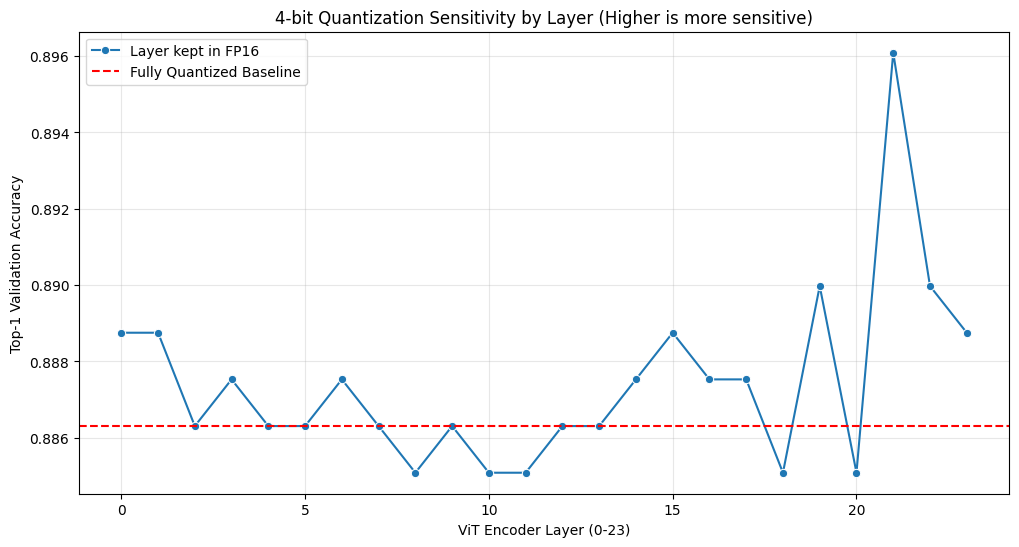

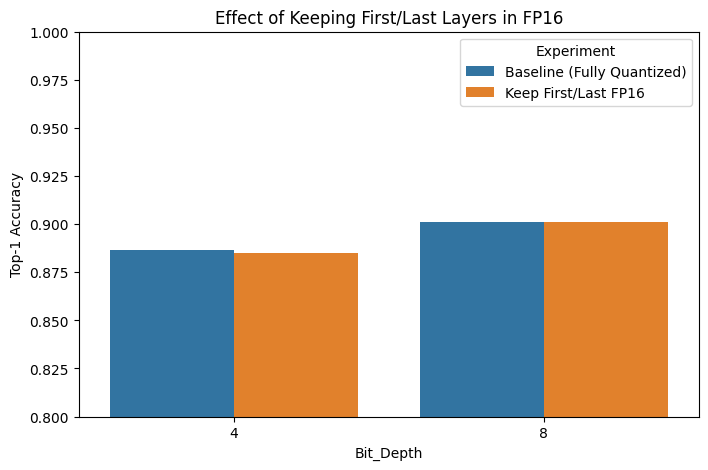

In [11]:
# Cell 9: Visualization of Sensitivity
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data
df_4bit = df_results[df_results["Bit_Depth"] == 4]
df_8bit = df_results[df_results["Bit_Depth"] == 8]

# Helper to plot layerwise sensitivity
def plot_layer_sensitivity(df, bit_depth):
    # Filter only the "Layer X" experiments
    layer_df = df[df["Experiment"].str.contains("Keep Layer")].copy()

    if layer_df.empty:
        print(f"No layerwise data for {bit_depth}-bit")
        return

    # Extract layer number
    layer_df["Layer_Num"] = layer_df["Experiment"].apply(lambda x: int(x.split(" ")[2]))
    layer_df = layer_df.sort_values("Layer_Num")

    # Get Baseline
    baseline = df[df["Experiment"].str.contains("Baseline")]["Top1_Acc"].values[0]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=layer_df, x="Layer_Num", y="Top1_Acc", marker="o", label="Layer kept in FP16")
    plt.axhline(baseline, color="r", linestyle="--", label="Fully Quantized Baseline")
    plt.title(f"{bit_depth}-bit Quantization Sensitivity by Layer (Higher is more sensitive)")
    plt.xlabel("ViT Encoder Layer (0-23)")
    plt.ylabel("Top-1 Validation Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 1. Plot 4-bit Layer Sensitivity (Usually most interesting)
plot_layer_sensitivity(df_4bit, 4)

# 2. Compare Special Cases (Baseline vs First/Last)
special_df = df_results[df_results["Experiment"].isin(["Baseline (Fully Quantized)", "Keep First/Last FP16"])]

plt.figure(figsize=(8, 5))
sns.barplot(data=special_df, x="Bit_Depth", y="Top1_Acc", hue="Experiment")
plt.title("Effect of Keeping First/Last Layers in FP16")
plt.ylim(0.8, 1.0) # Adjust based on your actual accuracy range for better visibility
plt.ylabel("Top-1 Accuracy")
plt.show()

In [12]:
# Final Export - Save Standard Quantized Models
# We reload the standard configurations one last time to save them cleanly.

print("=== Saving Final Models for Download ===")

# 1. Save 8-bit Model (Standard)
gc.collect(); torch.cuda.empty_cache()
q8_dir = os.path.join(BASE_DIR, "quant_8bit")
os.makedirs(q8_dir, exist_ok=True)

print("Saving standard 8-bit model...")
model_8bit = AutoModelForImageClassification.from_pretrained(
    merged_fp16_dir,
    quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    device_map="auto"
)
model_8bit.save_pretrained(q8_dir)

# 2. Save 4-bit Model (Standard)
gc.collect(); torch.cuda.empty_cache()
q4_dir = os.path.join(BASE_DIR, "quant_4bit")
os.makedirs(q4_dir, exist_ok=True)

print("Saving standard 4-bit model...")
model_4bit = AutoModelForImageClassification.from_pretrained(
    merged_fp16_dir,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    ),
    device_map="auto"
)
model_4bit.save_pretrained(q4_dir)

# 3. Zip and Provide Download Links
print("\n=== Zipping Files ===")
# Zip the ablation results CSV as well
save_and_zip(merged_fp16_dir, "merged_fp16.zip")
save_and_zip(q8_dir, "quant_8bit.zip")
save_and_zip(q4_dir, "quant_4bit.zip")

print("All tasks completed.")

=== Saving Final Models for Download ===
Saving standard 8-bit model...
Saving standard 4-bit model...

=== Zipping Files ===


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All tasks completed.
